In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


In [5]:
print(type(df["emergency_or_not"][0]))
df["emergency_or_not"] = df["emergency_or_not"].astype("str")
type(df["emergency_or_not"][0])

<class 'numpy.int64'>


str

(224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

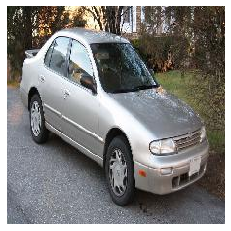

In [8]:
img = cv2.imread("images/1033.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)
plt.axis("off")

In [8]:
# df["emergency_or_not"] = df["emergency_or_not"].astype("category")

In [9]:
# X,Y= df["image_names"],df["emergency_or_not"]

In [10]:
# testing_set = []
# for i in X:
#     img_array = cv2.imread("images/"+i)
#     img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
#     new_array = cv2.resize(img_array, (128,128))
#     new_array = new_array/255.0
#     testing_set.append(new_array)

In [11]:
#plt.imshow(testing_set[0])

## Generating the model

In [9]:
# #first model -> model_01
# base_model = tf.keras.applications.VGG16(include_top = False, input_shape = (122,122,3))

# trainable = False
# for layer in base_model.layers:
#     if layer.name == "block6_conv1":
#         trainable = True
#     layer.trainable = trainable

# model = Sequential()
# model.add(base_model)
# model.add(Dropout(rate=0.25))
# model.add(Dense(1024,activation="relu"))
# model.add(BatchNormalization())
# model.add(Dense(512,activation="relu"))
# model.add(BatchNormalization())
# model.add(Dense(128,activation="relu"))
# model.add(Flatten())
# model.add(Dense(64,activation="relu"))
# model.add(BatchNormalization())
# model.add(Dense(2,activation="sigmoid"))
  
# opti = tf.keras.optimizers.Adam(
#     learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#     name='Adam')
# model.compile(optimizer=opti,loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
#  second-model -> model_02, resnet model
base_model = tf.keras.applications.ResNet50(include_top = False, input_shape = (122,122,3))

trainable = False
for layer in base_model.layers:
#     if layer.name == "":
#         trainable = True
    layer.trainable = trainable

model = Sequential()
model.add(base_model)
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(2,activation="sigmoid"))
  
opti = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
model.compile(optimizer=opti,loss="categorical_crossentropy",metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                2

## Generating images

In [22]:
train_datagen = ImageDataGenerator(rescale=1.0/255,shear_range=0.2,rotation_range=0.4,height_shift_range=0.2,zoom_range=0.2,
                                   validation_split=0.25)

In [23]:
TARGET_SIZE = 122
BATCH_SIZE = 128
EPOCHS = 15

In [24]:
training_data = train_datagen.flow_from_dataframe(dataframe = df,
                                            directory = "images/",
                                            x_col="image_names",
                                            y_col="emergency_or_not",
                                            target_size=(TARGET_SIZE,TARGET_SIZE),
                                            batch_size=BATCH_SIZE,
                                            shuffle= True,
                                            subset="training",
                                            class_mode = 'categorical')

Found 1235 validated image filenames belonging to 2 classes.


In [25]:
validate_data = train_datagen.flow_from_dataframe(dataframe = df,
                                            directory = "images/",
                                            x_col="image_names",
                                            y_col="emergency_or_not",
                                            target_size=(TARGET_SIZE,TARGET_SIZE),
                                            batch_size=BATCH_SIZE,
                                            shuffle= True,
                                            subset="validation",
                                            class_mode = 'categorical')

Found 411 validated image filenames belonging to 2 classes.


In [12]:
batch_x , batch_y = training_data.next()

In [13]:
batch_x.shape

(128, 122, 122, 3)

In [14]:
batch_y.shape

(128, 2)

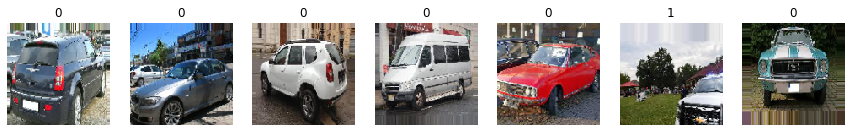

In [15]:
fig, axs = plt.subplots(1,7, figsize=(15,15)) # subplots will be in 2 rows and 5 columns
axs = axs.flatten() # flatten the axis into one single dimension
for img,yhat,ax in zip(batch_x[:7],batch_y[:7],axs):  # which is number of subplots we want to print
    ax.imshow(img, cmap="gray")
    labl = np.argmax(yhat)
    ax.title.set_text(labl)
    ax.axis("off")
plt.show() 

# Training the model

In [26]:
history = model.fit_generator(training_data,
                              epochs=EPOCHS,
                              steps_per_epoch=training_data.samples//BATCH_SIZE,
                              validation_data=validate_data,
                              validation_steps=validate_data.samples//BATCH_SIZE)

Epoch 1/15


ResourceExhaustedError: OOM when allocating tensor with shape[128,512,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

In [17]:
model.save("model_02.h5")